# Introduction to Logistic Regression

-----

In previous notebooks, we have seen how to perform linear regression on input data to predict a continuous value. In some cases, however, we wish to predict a categorical value, such as _True/False_ or _Yes/No_. Traditional regression methods are not optimal for these problems, since this requires the prediction of a discrete and not continuous value. In this notebook we introduce a technique that simulates linear regression, but with an additional function employed that maps the continuous value predicted by linear regression methods into a probability, or specifically the range $[0, 1]$. In this manner, we can apply a threshold to this probability to predict a binary response.

While several functions might be suitable for this transformation, the most popular
function is the [_logit_ function][wlf]. Note that some older analyses might reference the [_probit_ function][wpf]. Performing regression by using the logit function is known as [logistic regression][wlr] (the inverse of the logit function is known as the [_logistic_ function][wlcf]). The name might seem confusing since technically this algorithm is used to perform classification, but since logistic regression borrows heavily in its approach from linear regression, the descriptive name was maintained. A major benefit of logistic regression is the creation of a parametric model that can be explored to understand why predictions are made, in the same manner as a linear regression model.

In this notebook, we introduce the logit function and how it can be used to construct a binary model. Next, we introduce logistic regression, and specifically show how logistic regression can be performed by using estimators from the scikit-learn library. We also introduce several popular performance metrics and show how they can be calculated for binary classification tasks. We demonstrate logistic regression on several data sets, including one that contains categorical features. We also demonstrate how to perform logistic regression by using the statsmodels module with a formula interface, and introduce how to use this same formula interface with scikit-learn estimators. Finally, we discuss topics such as marginal effects and odds ratios, which are concepts that often prove useful in interpreting logistic regression models.

-----
[wlr]: https://en.wikipedia.org/wiki/Logistic_regression
[wlf]: https://en.wikipedia.org/wiki/Logit
[wpf]: https://en.wikipedia.org/wiki/Probit
[wlcf]: https://en.wikipedia.org/wiki/Logistic_function

## Table of Contents

[Formalism](#Formalism)

- [Logit Function](#Logit-Function)
- [Gradient Descent](#Gradient-Descent)
- [Logistic Modelling](#Logistic-Modelling)

[Logistic Regression](#Logistic-Regression)

- [Performance Metrics](#Performance-Metrics)
- [SGD Classifier](#SGD-Classifier)
- [LR: Tips Data](#LR:-Tips-Data)
- [Categorical Features](#Categorical-Features)
- [Formula-Based Method](#Formula-Based-Method)
- [Marginal Effects](#Marginal-Effects)
- [Odds-Ratio](#Odds-Ratio)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

-----

In a binary classification process, we have two possible outcomes, which for the sake of generality, we can label as _Success_ or _Failure_. Denoting the probability of these two outcomes as $P(S)$ and $P(F)$ respectively, we can write the probability of success as $P(S) = p$, and the probability of failure as $P(F) = 1 - p$. Thus, the odds of a successful outcome, which is the ratio of the probability of success to the probability of failure, is given by the following expression:

$\textrm{Odds}(S) = \frac{p}{1 - p}$

We can extend the framework of _linear regression_ to the task of binary classification by employing a mapping between the continuous value predicted by a linear regressor and the probability of an event occurring, which is bounded by the range $[0, 1]$. To do this, we need a function that maps the real numbers into this range, which enables a regression onto a set of discrete values (0 or 1) that provides us the binary classification. One popular choice for this function is the _logit_ function, while another choice is the _probit_ function. The use of these functions for a classification task leads to _logistic regression_ or _probit regression_. While we focus in this notebook on the application of logistic regression for the binary classification task, this approach can be generalized to classify into more than two categories, this more advanced technique is known as [multinomial logistic regression][mlr].

-----

[mlr]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

[[Back to TOC]](#Table-of-Contents)

### Logit Function

-----

$\DeclareMathOperator\erf{erf}$

The [_logit_ function][wl] is defined as the logarithm of the odds (i.e, $p/(1 - p)$), which is also known as the _log-odds_. Thus, the _logit_ function can be written for a probability of success $p$:

$\textrm{logit}(p) = \log\left(\frac{p}{1 - p}\right)$ where $0 \leq p \leq 1$. 

We can invert this relationship to obtain the [_logistic_ function][wlf], which for a parameter $\alpha$ is defined by the following expression:

$\textrm{logit}^{-1}(\alpha) = \textrm{logistic}(\alpha) = \frac{1}{1 + \exp{(-\alpha})}$

While the logistic function is most commonly used to perform this type of regression, a related function is the [_probit_ function][wp], which stands for _probability unit_ and is sometimes used in lieu of the _logit_ function. The _probit_ function is defined for a probability of success, $p$:

$\textrm{probit}(p) = \sqrt{2}\erf^{-1}(2p - 1)$ where $0 \leq p \leq 1$, and $\erf$ is the [Error Function][wef].

The logit function (and the probit function) is an _S_ shaped curve that converts real numbers into a probability. Both the logit and probit functions are related to the _sigmoid_ function, but are centered at the origin (0, 0). For the rest of this notebook, we will only consider the $\textrm{logit}$ function. In the following Code cell, we plot the $\textrm{logistic}$ function, or the inverse of the logit function, demonstrating how the real numbers can be mapped into the range $[0, 1]$.

-----
[wl]: https://en.wikipedia.org/wiki/Logit
[wp]: https://en.wikipedia.org/wiki/Probit
[wlf]: https://en.wikipedia.org/wiki/Logistic_function
[wef]: https://en.wikipedia.org/wiki/Error_function
[mlr]: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

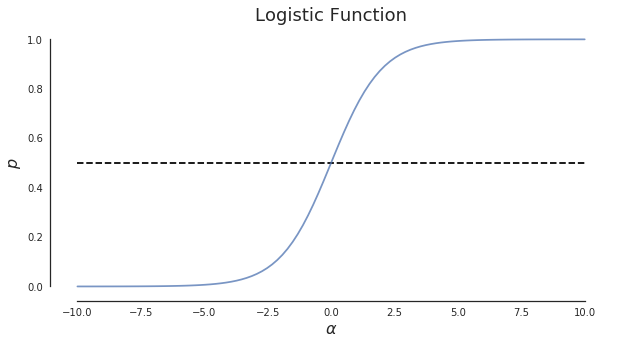

In [2]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Compute and plot logistic function
x = np.linspace(-10, 10, 100)
y = 1. / (1 + np.exp(-x))
ax.plot(x, y, alpha=0.75)

# Draw probability barrier
ax.hlines(0.5, -10, 10, linestyles='--')

# Decorate plot
ax.set_xlabel(r'$\alpha$', fontsize=16)
ax.set_ylabel(r'$p$', fontsize=16)
ax.set_title('Logistic Function', fontsize=18)
sns.despine(offset = 2, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

### Gradient Descent

-----

Given the previously defined _logistic_ function, we can develop the formalism of _logistic regression_ by first employing a linear regression model to predict a dependent variable from the set of independent features. Second, we apply the logistic function to the dependent variable in the linear regression model to make our binary classification prediction. Thus, if we have the following linear model:

$ y = mx + b$

the logistic regression model fits the following logistic model:

$ \textrm{logistic}(y) = \frac{1}{1 + \exp(-y)}$

The generally used cost (or loss) function for logistic regression is the sum of the squared errors between the actual classes and the predicted classes. One of the most popular techniques for finding the minimum of this cost function is to use [_stochastic gradient descent_][wsgd]. [Gradient descent][wgd] computes the derivate of (or finds the slope of the tangent line to) the cost function at a particular point. This can be used to modify the parameters of our model to move in a direction that is expected to reach the minimum of the cost function. Standard gradient descent computes these corrections by summing up all the contributions from each training data point. In stochastic gradient descent (or **SGD**), however, the corrections are computed for each training point. As a result, SGD often generates a path towards the minimum that is somewhat rambling, but this has the benefit of avoiding local minima and being more robust.

The following Code cell generates a figure to help explain gradient descent. A fictitious cost function is displayed, along with the tangent (or derivative) at a particular point. The arrows specify the direction that the derivative indicates we must move to reach the minimum. The repeated use of arrows signifies how an incremental approach to gradient descent, such as that employed by stochastic gradient descent, might converge to the true minimum of the cost function.

----
[wgd]: https://en.wikipedia.org/wiki/Gradient_descent
[wsgd]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent

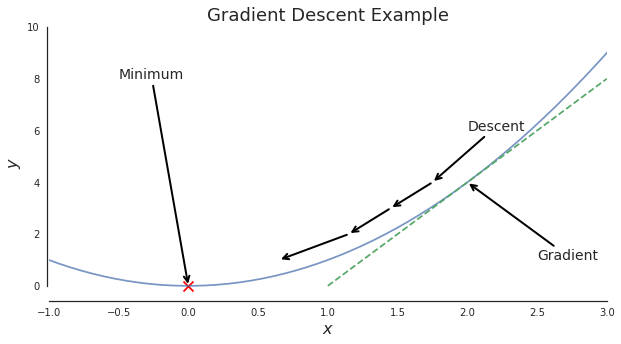

In [3]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Compute and plot logistic function
x = np.linspace(-4, 4, 100)
y = x**2
ax.plot(x, y, alpha=0.75)

# Draw probability barrier
ax.plot([1, 2, 3], [0, 4, 8], ls='--')
ax.scatter(0, 0, marker='x', c='r', s=100)

# Add text and arrow annotations
ax.annotate('Descent', xy=(1.75, 4), xytext=(2.0, 6), fontsize=14, 
    arrowprops=dict(arrowstyle="->", linewidth=2))

ax.annotate('Gradient', xy=(2, 4), xytext=(2.5, 1), fontsize=14, 
    arrowprops=dict(arrowstyle="->", linewidth=2))

ax.annotate('Minimum', xy=(0, 0), xytext=(-0.5, 8), fontsize=14,
    arrowprops=dict(arrowstyle="->", linewidth=2))

# Add extra arrows
ax.annotate('', xy=(1.45, 3), xytext=(1.75, 4), fontsize=14, 
    arrowprops=dict(arrowstyle="->", linewidth=2))
ax.annotate('', xy=(1.15, 2), xytext=(1.45, 3), fontsize=14, 
    arrowprops=dict(arrowstyle="->", linewidth=2))
ax.annotate('', xy=(0.65, 1), xytext=(1.15, 2), fontsize=14, 
    arrowprops=dict(arrowstyle="->", linewidth=2))


# Limit plot boundaries
ax.set_xlim(-1, 3)
ax.set_ylim(-0.5, 10)

# Decorate plot
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$y$', fontsize=16)
ax.set_title('Gradient Descent Example', fontsize=18)
sns.despine(offset = 2, trim=True)

-----

The scikit-learn library has a standard `LogisticRegression` and an `SGDRegression` estimator. In this notebook, we demonstrate both estimators; however, the latter is a general technique that uses SGD to minimize the cost function. By specifying the `log` value to the `loss` hyperparameter, we can use the `SGDRegression` estimator to perform logistic regression. This can be very useful, especially in a teaching situation, since, by default, the `LogisticRegression` estimator performs regularization, which we have not yet covered (but will in a later notebook). Regularization is a technique to minimize the likelihood of over-fitting and works by penalizing complex models, which, in effect, alters the coefficients of our logistic regression model. 

-----

[[Back to TOC]](#Table-of-Contents)

### Logistic Modelling

Before introducing logistic regression, we first show how the logistic function can be used to model binary response data. For this purpose, we will use data from NASA on the relationship between the outside temperature when the space shuttle was launched, and the occurrence of a thermal failure of an O-ring on a booster rocket. We will use this data to create a predictive model between temperature and thermal failure; note that it is believed that the [failure of an O-ring][wsrb] on a solid rocket booster led to the Challenger disaster.

The [actual data][ord] we use is hosted at the University of California at Irvine (UCI) machine learning data repository. The following two code cells first create the full path and filename for your local copy of this data. If this file already exists, the code displays a message to this effect, while if the file does not exist, we pull it from the UCI ML data repository. Note that this approach will be used repeatedly in these notebooks to grab new data sets from this repository.

-----
[wsrb]: https://en.wikipedia.org/wiki/Space_Shuttle_Solid_Rocket_Booster#Challenger_disaster
[ord]: https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/

In [4]:
# O-ring data file from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/

# First we find our HOME directory
tmp = !echo $HOME

# Then we create a temporary working directory to store data files in
!mkdir ~/temp_w2l1

# We construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/temp_w2l1/o-ring-erosion-only.data'

mkdir: cannot create directory ‘/home/data_scientist/temp_w2l1’: File exists


In [5]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/space-shuttle/o-ring-erosion-only.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

Now that the data have been acquired, we next read the data into a Pandas DataFrame. To simplify this process, we explicitly list the feature names, which were obtained from the UCI ML data repository (each data set includes both data and a description of the data). In this case, we have five features, the second of which, `Number_TD`, is the feature that we  wish to predict since it corresponds to the number of thermal failures. One caveat to this example is that normally the concept of success is denoted by one and failure by zero. This example, however, inverts that since zero thermal distresses indicates success.

After reading in the data, we display a random sample of five instances. The second Code cell computes and displays descriptive statistics for the entire data set.

------

In [6]:
# Challenger disaster O-ring data

# Feature names taken from UCI repository
col_names = ['Number', 'Number_TD', 'Temperature', 'Pressure', 'Order']

# Read in data, delimited by whitespace, use feature names
cdata = pd.read_csv(data_file, delim_whitespace=True, 
                    index_col=False, names = col_names)
cdata.sample(5)

,Number,Number_TD,Temperature,Pressure,Order
7,6,0,70,100,8
22,6,1,58,200,23
10,6,1,70,200,11
4,6,0,67,50,5
19,6,0,79,200,20


In [7]:
# Descriptive statistics
cdata.describe()

,Number,Number_TD,Temperature,Pressure,Order
count,23.0,23.000000,23.000000,23.000000,23.00000
mean,6.0,0.304348,69.565217,152.173913,12.00000
std,0.0,0.558796,7.057080,68.221332,6.78233
min,6.0,0.000000,53.000000,50.000000,1.00000
25%,6.0,0.000000,67.000000,75.000000,6.50000
50%,6.0,0.000000,70.000000,200.000000,12.00000
75%,6.0,0.500000,75.000000,200.000000,17.50000
max,6.0,2.000000,81.000000,200.000000,23.00000


-----

From this summary description we can identify several important points. First, there are 23 instances in this data set. Second, this summary indicates that there are no missing values, since each feature has the same number in the `count` row, and the `min` row always contains a valid number. On the other hand, we notice that the maximum value for the number of thermal distresses is two, not one like we require for a binary classification task, which should be zero or one. Thus, our next step is to determine how many instances have a value of 2 for the `Number_TD` feature. We perform this test by applying a Boolean filter to the DataFrame in the following Code cell.

-----

In [8]:
cdata[cdata.Number_TD > 1]

,Number,Number_TD,Temperature,Pressure,Order
13,6,2,53,200,14


-----

As the output demonstrates, we only have one instance that records more than one thermal distress. At this point we have three options:

1. delete this instance,
2. duplicate this instance so that two single failure instances exist in the data set, or
3. change this instance to report only a single thermal distress.

While any of these options might be valid from an algorithmic perspective, they differ from a modeling perspective. The first option would remove valuable data from our set, which is already small. This would also make our model less predictive since this was an actual failure, and we likely do not want to under predict failures, which could have devastating effects. On the other hand, duplicating this instance would be the same as having two separate launches at the same temperature. This could also be problematic, as it would overemphasize a failure at a given temperature.

As a result, we will instead convert this instance to a single thermal distress. The reason in this case is that this measurement did find an instance of a thermal distress, and we are creating a model between temperature and the probability of a thermal failure. We perform this conversion in the following Code cell, where we find the instance where the number of thermal distresses is higher than one, and explicitly modify the `Number_TD` feature to be one. The second Code cell confirms that this change did take place.

-----

In [9]:
# Modify instance with multiple thermal distresses
cdata.loc[cdata['Number_TD'] > 1, 'Number_TD' ] = 1

In [10]:
# Display the new number of thermal distesses
cdata.loc[13].Number_TD

1

-----

Now that our data are prepared, we can model this data by using a logit function. To do this we will use the statsmodels module. Our first step is to construct our feature and label arrays. For the former, we extract the `Temperature` feature and explicitly add a constant term so that we start with a linear regression. Next, we create a logit estimator, and fit this estimator to the feature and label arrays. Finally, we display the best fit intercept and slope (via the coefficient array) terms.

-----

In [11]:
import statsmodels.api as sm
features = sm.add_constant(cdata['Temperature'], prepend=False)
label = cdata['Number_TD']
lgt_model = sm.Logit(label, features)
lgt = lgt_model.fit()
print('\n', lgt.params)

Optimization terminated successfully.
         Current function value: 0.313604
         Iterations 8

 Temperature    -0.366701
const          23.774955
dtype: float64


-----

We can now compare the newly generated logit model to the original data. The following Code cell first converts the logit model to a set of predictive values to compare with our data. This task is accomplished by generating a set of linearly spaced independent values spanning the temperature range of interest. Next, we compute values at these temperatures by using our logit model. Finally, we convert this to a logistic function. One last requirement is that we must subtract our model from one since our model was trained to predict failures and not successes (thus a predicted one goes to zero and predicted zero goes to one). The rest of the code generates a plot showing the original data and our predictive values.


-----

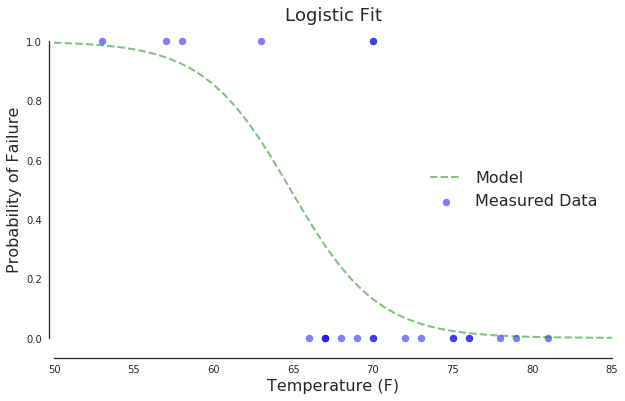

In [12]:
x = np.linspace(50, 85)
lgy = lgt.params['const'] + lgt.params['Temperature'] * x

# We subtract fit from one since in the data fail = 1.
# A normal logit model is fail = 0
y = 1 - 1.0 / (1.0 + np.exp(lgy))

# Make the plots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data and model
plt.scatter(cdata['Temperature'], cdata['Number_TD'],
            c='b', alpha = 0.5, label=f'Measured Data')
ax.plot(x, y, c='g', alpha = 0.5, lw=2, linestyle='--', label='Model')
    
# Decorate plot appropriately
ax.set_title('Logistic Fit', fontsize=18)
ax.set_xlabel('Temperature (F)', fontsize=16)
ax.set_ylabel('Probability of Failure', fontsize=16)
ax.set_xlim(50, 85)
ax.set_ylim(-0.05, 1.05)
ax.legend(loc=7, fontsize=16)
sns.despine(offset=5, trim=True)

-----

Given a predictive model such as our computed logit model, we can also predict for new, unseen data. In this case, we can predict the probability of thermal failure for a given temperature. The following Code cell computes and displays these probabilities as a function of temperature. Note, that the temperature at launch during the Challenger disaster was 36 degrees Fahrenheit.

-----

In [13]:
# Compute the probability of failure for different temperatures
for t in [36, 58, 65, 72, 88]:
    str = f'P(Fail) of O-Ring at {t} deg. = {lgt.predict([t, 1])[0]:4.2f}%'
    print(str)

P(Fail) of O-Ring at 36 deg. = 1.00%
P(Fail) of O-Ring at 58 deg. = 0.92%
P(Fail) of O-Ring at 65 deg. = 0.48%
P(Fail) of O-Ring at 72 deg. = 0.07%
P(Fail) of O-Ring at 88 deg. = 0.00%


-----

[[Back to TOC]](#Table-of-Contents)

## Logistic Regression

-----

We can also compute a logistic regression to these data by using the scikit-learn library. In this case, we will use the `LogisticRegression` estimator. This estimator accepts a number of hyperparameters, of which the most important for our purposes include:

- `C`: inverse of regularization strength
- `class_weight`: weights to be applied to classes when performing regression, default is uniform
- `penalty`: type of regularization to be applied, can be `l1` or `l2`, both of which will be discussed in a future notebook
- `fit_intercept`: specifies if a constant term should be included in the regression, the default is `True`
- `random_state`: the seed used to initialize the random number generator, a constant value ensures reproducibility.

To minimize the effects of regularization, we will introduce a high value for the `C` hyperparameter, which will reduce the impact of regularization on our model fit. The following Code cell creates this estimator, which we will use in the next section of this notebook.

------

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1E6)

-----

#### Training/Testing

In the statsmodels logistic regression, we used *all* of the data to fit the regressor and visualize the result. In practice, this is not a good idea, since we will have little idea how well our regressor will perform on new, unseen data. A better approach is to train on a subset of the data and test this new regressor on unseen _test_ data. Formally, we wish to construct separate _training_ and _testing_ data sets. The scikit-learn library supports this operation directly by using the `train_test_split` method in the `model_selection` module. 

In the following code cell, we split our original data such that 60% of the data is used for training and 40% is used for testing. This is done via the `test_size` parameter. Since we only have 23 original instances, we also use the `stratify` parameter to ensure that our training and testing data sets maintain roughly equivalent ratios of the success and failure. This ensures we don't train a model on unbalanced data or try to predict future performance by using unbalanced data. Finally, we specify a `random_state` to ensure reproducibility.

Once our data have been divided into these two samples, we fit our new logistic regression model and use it to predict on our test data. Finally, we display the model parameters, which in this case are the intercept and slope for our linear model. The second Code cell displays the temperature for each instance in the test data set, as well as the predicted result to explore the impact of our model.

-----

In [15]:
from sklearn.model_selection import train_test_split

features = cdata['Temperature'].reshape(23, 1)
labels = cdata['Number_TD'].reshape(23, 1)

# Evaluate the model by splitting into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.4, 
                                                    stratify = labels,
                                                    random_state=23)

# Fit a new model and predict on test data
lr_model = model.fit(x_train, y_train)
predicted = lr_model.predict(x_test)

# Compute model values
slope = lr_model.coef_[0][0]
intercept = lr_model.intercept_[0]

print(f'LR Model Fit: {intercept:4.2f} + {slope:4.2f} * Temperature')

LR Model Fit: 25.59 + -0.39 * Temperature


In [16]:
# Display data and predicted labels
for data, label in zip(x_test, predicted):
    print(data, label)

[58] 1
[67] 0
[78] 0
[53] 1
[67] 0
[70] 0
[75] 0
[70] 0
[70] 0
[76] 0


-----

If you look carefully, you will notice that our model fit values differ from those computed by the statsmodels module, although they are close. This is simply the result of the fact that we only used 60% of the original data to fit a logistic regression by using the scikit-learn library, thus there should be differences. We can now use the scikit-learn library to compute and display performance metrics. In the first Code cell we compute and display an accuracy score as well as display the full classification report. In the second Code cell we display the confusion matrix for this predictive model and the testing data, which we generate and display by using a helper function located in the mlplots.py file in the helper_code module.

-----

In [17]:
from sklearn.metrics import accuracy_score, classification_report

# Generate and display different evaluation metrics
score = 100.0 * accuracy_score(y_test, predicted)
print(f'Logistic Regression [Challenger Data] Score = {score:4.1f}%\n')

print(classification_report(y_test, predicted))

Logistic Regression [Challenger Data] Score = 90.0%

             precision    recall  f1-score   support

          0       0.88      1.00      0.93         7
          1       1.00      0.67      0.80         3

avg / total       0.91      0.90      0.89        10



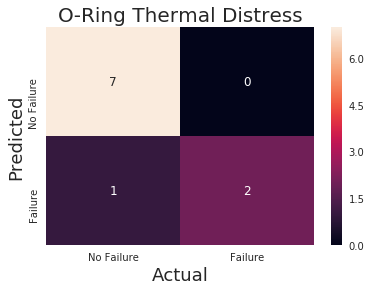

In [18]:
# Display confusion matrix for the binary classification
# example by using our helper function

from helper_code import mlplots as ml

ml.confusion(y_test.reshape(y_test.shape[0]), 
             predicted, ['No Failure', 'Failure'], 2, 'O-Ring Thermal Distress')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used logistic regression to build a model representation of the O-ring data to predict if the O-ring might suffer thermal distress or not. Now that you have run the notebook once, go back and make the following changes. Be sure to understand what you have done and the impact on the new classification result.

1. In this model, we changed one original instance that had two thermal distresses to only have one. Instead, add a new instance so that both original thermal distresses are recorded properly. Recompute the logistic model on this new data. Do you believe the new model more or less than the original model? Why?
2. Try including another feature in the model, such as `pressure` or `order`, one at a time. Do either of these features improve the performance?

-----

-----

[[Back to TOC]](#Table-of-Contents)

### Performance Metrics

In a binary classification problem, like the O-ring classification task, we generate a confusion matrix that has four elements. In this case, we can explicitly label each element by its result, as shown in the following table.

|  | |
| --- |--- |
| True  Negative (**TN**)| False Positive (**FP**)|
| False Negative (**FN**)| True Positive (**TP**)|

Note that in our O-ring example, a success was that the O-ring did not fail, which corresponded to a zero, or the usual definition of a negative result in a binary classification example. Thus, we have the following results from our O-ring classification demonstration:

- $TN = 7$
- $FP = 0$
- $FN = 1$
- $TP = 2$

This means that we correctly predicted seven launches would not have O-ring failures (**TN**), while two launches would have O-ring failures (**TP**). On the other hand, we incorrectly predicted that one launch would have an O-ring failure when it didn't (**FN**), but we did miss predicting any real failures (**FP**). This last point is important to highlight. In certain cases, it may be very important to ensure that a model does not incorrectly predict, or alternatively fail to predict, a certain result. Here, it is better to predict a failure and possibly scrub a shuttle launch, rather than miss a potential problem and have a disastrous launch.

In the binary classification case it is easy to compute a number of performance metrics, of which there are many. A full analysis of the all classification performance metrics is beyond the scope of this notebook, for more information look at Wikipedia's discussion on the [confusion matrix][wcm]. We can, however, relate these four quantities to a number of standard performance metrics, including the precision, recall, and the F1-score, as shown in the following table.

| | | |
| -- | -- | -- |
| Precision |  Positive Predictive Value | $\frac{TP}{TP + FP}$ |
| Accuracy |   | $\frac{TP + TN}{TP  + TN + FP + FN}$ |
| Recall (Sensitivity) |  True Positive Rate | $\frac{TP}{TP + FN}$ |
| F1-score ($F_1$)|  Harmonic mean of Precision and Recall | $\frac{2TP}{2TP + FN + FP}$ |
| Specificity |  True Negative Rate | $\frac{TN}{TN + FP}$ |
| False Positive Rate (Fall Out)|  FPR | $\frac{FP}{FP + TN}$ |
| False Discovery Rate |  FDR | $\frac{FP}{FP + TP}$ |

In addition to these performance metrics, we also have two commonly used terms that characterize classification mistakes.   
  
-----
<dl>
  <dt>Type I Error</dt>
  <dd>False Positive: Predicting a condition is true when it is false, hence a _False Hit_.</dd>
  
<dt>Type II Error</dt>
  <dd>False Negative: Predicting a condition is false when it is true, a _Miss_.</dd>
</dl>

-----

These terms were originally popularized in  [_Hypothesis Testing_][wht], a classical statistical technique that is not covered in this course. The following two code cells compute several of these metrics by using the relations displayed in the previous table and functions in the [scikit-learn metrics][skm] module that compute performance metrics. Note, these values will different from those reported by the `classification_report` function, which generates per-class values.

-----
[wcm]: https://en.wikipedia.org/wiki/Confusion_matrix
[skm]: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
[wht]: https://en.wikipedia.org/wiki/Statistical_hypothesis_testing

In [19]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test.reshape(y_test.shape[0]), predicted).ravel()

print('Computed metrics from the confusion matrix')
print(42*'-')
print(f'Precision   = {100.0 * tp/(tp + fp):5.2f}%')
print(f'Accuracy    = {100.0 * (tp + tn)/(tp + tn + fp + fn):5.2f}%')
print(f'Recall      = {100.0 * tp/(tp + fn):5.2f}%')
print(f'F1-score    = {100.0 * 2 * tp/(2 * tp + fp + fn):5.2f}%')

Computed metrics from the confusion matrix
------------------------------------------
Precision   = 100.00%
Accuracy    = 90.00%
Recall      = 66.67%
F1-score    = 80.00%


In [20]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Computed metrics from the scikit-learn module')
print(45*'-')
print(f'Precision   = {100.0 * precision_score(y_test, predicted):5.2f}%')
print(f'Accuracy    = {100.0 * accuracy_score(y_test, predicted):5.2f}%')
print(f'Recall      = {100.0 * recall_score(y_test, predicted):5.2f}%')
print(f'F1-score    = {100.0 * f1_score(y_test, predicted):5.2f}%')

Computed metrics from the scikit-learn module
---------------------------------------------
Precision   = 100.00%
Accuracy    = 90.00%
Recall      = 66.67%
F1-score    = 80.00%


-----

As the output from the previous two Code cells confirms, these performance metrics for our binary classification task agree with the theoretical expectations. We now turn to a visual comparison of our model and data. We first compute our model, as before, but now by using the model coefficients from the scikit-learn estimator. We also compute predicted values from our estimator, and display them all in the following figure. As demonstrated in the figure, our model provides probabilistic predictions, but the estimator predicts binary classification where the probability threshold is by default set to 50%.

-----

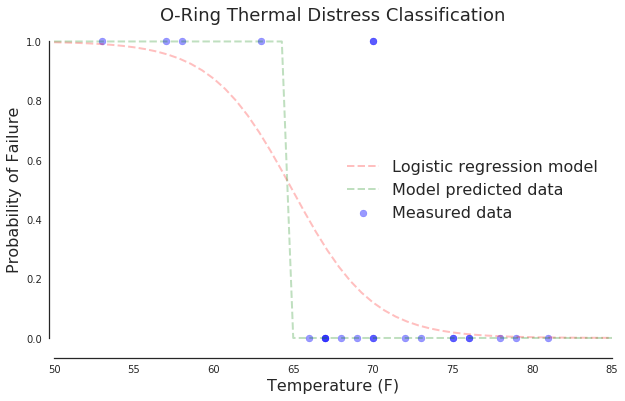

In [21]:
# Sample points
x = np.linspace(50, 85)

# Compute Model
lgy = lr_model.intercept_[0] + lr_model.coef_[0][0] * x
y = 1.0 - 1.0 / (1.0 + np.exp(lgy))

# Predicted data
y2 = lr_model.predict(x.reshape(x.shape[0], 1))

# Make the plots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data and model
plt.scatter(cdata['Temperature'], cdata['Number_TD'],
            c='b', alpha = 0.4, label=f'Measured data')
ax.plot(x, y, c='r', alpha = 0.25, lw=2, linestyle='--', label='Logistic regression model')
ax.plot(x, y2, c='g', alpha = 0.25, lw=2, linestyle='--', label='Model predicted data')

# Decorate plot appropriately
ax.set_title('O-Ring Thermal Distress Classification', fontsize=18)
ax.set_xlabel('Temperature (F)', fontsize=16)
ax.set_ylabel('Probability of Failure', fontsize=16)
ax.set_xlim(50, 85)
ax.set_ylim(-0.05, 1.05)
ax.legend(loc=7, fontsize=16)
sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

### SGD Classifier

We now turn to the alternative technique for performing logistic regression with the scikit-learn library. We can employ a stochastic gradient descent classifier to perform logistic regression by specifying a logarithmic `loss` function (or cost function in our previous terminology). This has several benefits over the standard logistic regression estimator in the scikit-learn library. First, this technique employs stochastic gradient descent, which can be efficient in finding the minimum of the cost function, especially with large, complex data sets. Stochastic gradient descent is based on standard gradient descent that was demonstrated graphically earlier, but is less prone to being trapped in local minima (or valleys).

Second, this estimator does not automatically employ regularization, a technique designed to reduce overfitting. The standard logistic regression estimator employs the `C` hyperparameter to control the amount of regularization used to minimize the cost function. As a result, we were forced to choose a high value for `C`, which effectively turns off the regularization.

The following Code cell demonstrates the use of the `SGDClassifier` with a logarithmic loss function to perform logistic regression on the O-ring data. As the output displays, the results match those from the standard logistic regression estimator when we minimized the effects of regularization.

-----

In [22]:
from sklearn.linear_model import SGDClassifier

# Create SGD estimor with log loss
sgd_model = SGDClassifier(loss='log')

# Fit training data and predict for test data
sgd_model = model.fit(x_train, y_train)
predicted = sgd_model.predict(x_test)

# Display performance metrics
score = 100.0 * accuracy_score(y_test, predicted)
print(f'Logistic Regression [Challenger Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    classification_report(y_test, predicted)))

# Display logistic model
slope = sgd_model.coef_[0][0]
intercept = sgd_model.intercept_[0]
print(f'SGD Model Fit: {intercept:4.2f} + {slope:4.2f} * Temperature')

Logistic Regression [Challenger Data] Score = 90.0%

Classification Report:
              precision    recall  f1-score   support

          0       0.88      1.00      0.93         7
          1       1.00      0.67      0.80         3

avg / total       0.91      0.90      0.89        10


SGD Model Fit: 25.59 + -0.39 * Temperature


-----

[[Back to TOC]](#Table-of-Contents)

### LR: Tips Data

While the O-ring data was informative, it was small in both number of features and instances. As a result, we will now transition to the _tips_ data included with the Seaborn library. This data set has 244 instances and seven features. In the following Code cell we load this data set into a DataFrame and display five random instances. As the output demonstrates, we have three numeric features: `total_bill`, `tip`, and `size`, and four categorical features: `sex`, `smoker`, `day`, and `time`. With this data set, we will first demonstrate logistic regression using only numeric features before including categorical features as well.

-----

In [23]:
# Load tips data set
tdf = sns.load_dataset('tips')

# Display several random rows
tdf.sample(5)

,total_bill,tip,sex,smoker,day,time,size
130,19.08,1.50,Male,No,Thur,Lunch,2
229,22.12,2.88,Female,Yes,Sat,Dinner,2
86,13.03,2.00,Male,No,Thur,Lunch,2
88,24.71,5.85,Male,No,Thur,Lunch,2
104,20.92,4.08,Female,No,Sat,Dinner,2


-----

To perform regression on the numeric features, we need both the numerical features and a target feature. For this example, we will attempt to predict if a patron is a smoker or not based solely on the three numerical features. The following Code cell first extracts the numerical features into a new DataFrame (for the independent variables), before constructing a NumPy array to hold the labels (or the dependent variable). The construction of the NumPy array is simplified by performing the Boolean test for the `smoker` feature of the `tdf` DataFrame, and converting these Boolean values (i.e., `True/False`) to numerical values (i.e, `0/1`).

-----

In [24]:
# Extract dependent variable
labels = (tdf.smoker == 'Yes').astype(float)

# Extract numerical features as a DataFrame
numerical = ['total_bill', 'tip', 'size']
num_data = tdf[numerical]

# Sample DatFrame
num_data.sample(5)

,total_bill,tip,size
137,14.15,2.0,2
176,17.89,2.0,2
156,48.17,5.0,6
28,21.70,4.3,2
170,50.81,10.0,3


-----

Given the independent and dependent variables, we are ready to construct our logistic regression model. First, we separate the data into training and testing sets. This requires reshaping our `labels` array to be properly sized for the scikit-learn library estimators (244, 1). Next, we create our `LogisticRegression` estimator, using a large value for the `C` hyperparameter to minimize any regularization. Next, we fit our estimator to the training data, predict on the testing data and display performance metrics. In the second Code cell, we also display the confusion matrix. 

-----

In [25]:
# We want to split our data into training and testing
from sklearn.model_selection import train_test_split

# This is the amount to hold out for 'blind' testing
frac = 0.25

# We must reshape the label array to ensure it is of size
# (Num_Samples, Num_Features) or (244, 1) in this case
labels = labels.reshape(labels.shape[0], 1)

# Create test/train splits for independent and dependent data, and
# explicitly set our random seed to enable reproduceability
ind_train, ind_test, dep_train, dep_test \
    = train_test_split(num_data, labels, stratify=labels,
                       test_size=frac, random_state=23)

# Create and fit a new LR model
tips_model = LogisticRegression(C=1E6)
tips_model.fit(ind_train, dep_train)

# Predict values, and compute and display performance
predicted = tips_model.predict(ind_test)

score = 100.0 * accuracy_score(dep_test, predicted)
print(f'Smoker [Numeric only] classification score = {score:4.2f}%')
print(classification_report(dep_test, predicted))

Smoker [Numeric only] classification score = 62.30%
             precision    recall  f1-score   support

        0.0       0.64      0.92      0.75        38
        1.0       0.50      0.13      0.21        23

avg / total       0.58      0.62      0.55        61



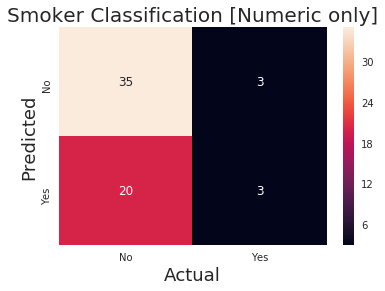

In [26]:
from helper_code import mlplots as ml

ml.confusion(dep_test.reshape(dep_test.shape[0]), 
             predicted, ['No', 'Yes'], 2, 'Smoker Classification [Numeric only]')

-----

In this simple example, our model provides a reasonable performance, except for the excess _false negatives_ where we over predict non-smokers to be smokers. While there are several techniques we could explore to improve the performance of this simple model, the easiest will be to include additional features in our model. This will require including categorical features in our model, which is discussed in the next section.

----

[[Back to TOC]](#Table-of-Contents)

### LR: Categorical Features

Admittedly, our attempt to predict whether a patron is a smoker or not, based solely on the data in the _tips_ data set, is ambitious. Even if the model fails to perform sufficiently well, we may gain insight into our data and the relationship between the features. As a result, we now transition to include categorical features in the model. To accomplish this we need to transform the single categorical feature into multiple features that correspond to the different values available to each categorical feature. In the linear regression notebook, this was performed by using the `LabelBinarizer` in the scikit-learn library. 

Here we will use a different approach; the pandas library provides a `get_dummies` method that creates a new DataFrame from the categorical features in an existing DataFrame. A dummy feature is a binary feature that takes a value of `0` or `1` depending on whether the original feature had the corresponding categorical value. We demonstrate this in the following Code cell, where we extract the three categorical features: `sex`, `day`, and `time` from the `tdf` DataFrame, generate dummy features, and sample the resulting DataFrame.

-----



In [27]:
categorical = ['sex', 'day', 'time']

cat_data = pd.get_dummies(tdf[categorical])
cat_data.sample(5)

,sex_Male,sex_Female,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
71,0,1,0,0,1,0,0,1
202,0,1,1,0,0,0,1,0
126,1,0,1,0,0,0,1,0
232,1,0,0,0,1,0,0,1
197,0,1,1,0,0,0,1,0


-----

With these _dummy_ categorical features, we can compute a logistic regression model for the combined numeric and categorical features. To do this, we first combine the numeric and categorical features into a new DataFrame. Next, we divide the features and labels into training and testing data. We fit our existing estimator to the new data, and display the results. As the output of the first Code cell, which displays the classification report, and the second Code cell, which displays the confusion matrix, demonstrate, the inclusion of the categorical features improves the overall result.

-----

In [28]:
# Join numerical and categorical features
# into new DataFrame
features = pd.concat([num_data, cat_data], axis=1)

# Create test/train splits for independent and dependent data
# Explicitly set our random seed to enable reproduceability
ind_train, ind_test, dep_train, dep_test \
    = train_test_split(features, labels, test_size=frac, random_state=23)

# Fit a new model to new data
tips_model.fit(ind_train, dep_train)

# Predict on test data
predicted = tips_model.predict(ind_test)

# Generate and display different evaluation metrics
score = 100.0 * accuracy_score(dep_test, predicted)
print(f'Smoker [Numeric & Categoric] classification score = {score:4.2f}%')
print(classification_report(dep_test, predicted))

Smoker [Numeric & Categoric] classification score = 72.13%
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82        42
        1.0       0.60      0.32      0.41        19

avg / total       0.70      0.72      0.69        61



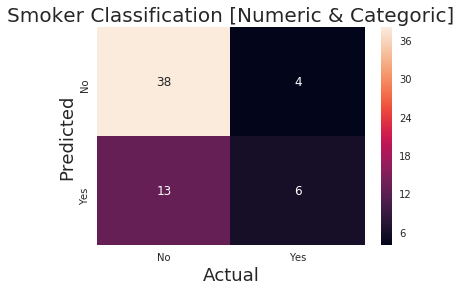

In [29]:
ml.confusion(dep_test.reshape(dep_test.shape[0]), 
             predicted, ['No', 'Yes'], 2, 'Smoker Classification [Numeric & Categoric]')

-----

We can display the coefficients of our logistic regression model to understand which features contribute the most to future predictions. Simply put, the higher a coefficient, the more important that corresponding feature. In addition, a positive coefficient contributes towards a positive classification, while a negative coefficient contributes in the opposite manner. 

The following Code cell displays the fit coefficients for each feature in our data set, and the results are interesting. Recall that we are trying to predict if a patron is a smoker or not, thus a positive classification would indicate the patron is predicted to be a smoker. First, our model indicates that more patrons at lunch are smokers as opposed to dinner. Second, more smokers are predicted on Friday, while more non-smokers are predicted on Thursday. Finally, as the size of the group increases, the model predicts fewer smokers. Whether these model insights make sense or not is a matter for debate; however, this does demonstrate one of the important results of logistic regression, we end up with a parametric model that we can explore for insights.

-----

In [30]:
# Display coefficients for different features
for c, f in zip(tips_model.coef_[0], features.columns.values):
    print(f'{c:5.2f} * {f}')

 0.07 * total_bill
-0.08 * tip
-0.59 * size
 0.35 * sex_Male
 0.58 * sex_Female
-6.48 * day_Thur
 3.33 * day_Fri
 2.40 * day_Sat
 1.68 * day_Sun
 4.61 * time_Lunch
-3.68 * time_Dinner


-----

[[Back to TOC]](#Table-of-Contents)

### Formula-Based Method


As the previous example demonstrated, the machine learning estimators in the scikit-learn library operate on NumPy arrays (or DataFrames that are converted into NumPy arrays). However, we can construct a pandas DataFrame from our data, and use the formula interface to the statsmodels module regression estimator to construct a logistic regression model. To demonstrate this formula-based approach, we perform logistic regression on the _tips_ data set. First, we add a new binary feature in our data for our dependent variable, which in this case is the `label` data that indicates whether a patron was a smoker or not.

The first Code cell below adds this feature to the `tdf` DataFrame and randomly samples and displays five instances. The second Code cell builds a logit regression model by using the statsmodels module and a formula relating the dependent variable (`label`) to the independent variables (`total_bill`, `tip`, and `size`). Once constructed, we display the model results. Note that, in this case, we have not created and used training and testing data sets, thus we cannot accurately predict future performance.

-----

In [31]:
# Generate new feature in our DataFrame for the label
tdf['label'] = (tdf['smoker'] == 'Yes').astype(float)
tdf.sample(5)

,total_bill,tip,sex,smoker,day,time,size,label
173,31.85,3.18,Male,Yes,Sun,Dinner,2,1.0
105,15.36,1.64,Male,Yes,Sat,Dinner,2,1.0
161,12.66,2.50,Male,No,Sun,Dinner,2,0.0
187,30.46,2.00,Male,Yes,Sun,Dinner,5,1.0
139,13.16,2.75,Female,No,Thur,Lunch,2,0.0


In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Implement simple regression: Result ~ Input
sts_model = logit('label ~ total_bill + tip + size', data=tdf).fit()

# Display summary of model and fit parameters
sts_model.summary()

Optimization terminated successfully.
         Current function value: 0.632211
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                  244
Model:                          Logit   Df Residuals:                      240
Method:                           MLE   Df Model:                            3
Date:                Fri, 26 Jan 2018   Pseudo R-squ.:                 0.04877
Time:                        13:59:11   Log-Likelihood:                -154.26
converged:                       True   LL-Null:                       -162.17
                                        LLR p-value:                  0.001236
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0903      0.434      0.208      0.835      -0.759       0.940
total_bill     0.0712      0.024      2.982      0.003       0.024       0.118
tip           -0.0846      0.137     -0.616      0.538      -0.354       0.184
size          -0.6866      0.206     -3.335      0.001      -1.090      -0.283
==============================================================================
"""

-----

The displayed fit coefficient results agree, to a degree, with our earlier results. The `total_bill` and `tips` features show a small impact on our predicted result, while the `size` is negatively correlated with a positive prediction. Naively, we might interpret this as smokers tend to visit the restaurant in smaller groups or individually. We can display the confession matrix for these data, as demonstrated in the following Code cell. This shows this new model fails primarily with false negatives.

-----

In [33]:
# Display confusion matrix
sts_model.pred_table()

array([[ 140.,   11.],
       [  72.,   21.]])

-----

We can also employ a formula-based approach with the scikit-learn library by using the patsy module to construct NumPy matrices from a formula. This is actually how the statsmodels library constructs NumPy arrays for regression models, but in this case we avoid using statsmodels. 

To demonstrate this, we will once again perform logistic regression on the _tips_ data set. Since we have already constructed our DataFrame with both numeric, categorical, and label features, we can simply supply a formula to the patsy library to generate the desired NumPy matrices. We demonstrate this in the following code cell, where we regress on the same three numerical features, but now add in three categorical features. To indicate to the patsy module that a feature is categorical, we enclose the feature in parenthesis and prefix this with a `C`.

The `dmatrices` function takes this formula and the supplied data and returns the aggregated result, which in this case we have requested as two DataFrames: `x` for the independent variables and `y` for the dependent variable. We reshape the `y`, or label DataFrame, to work with the scikit-learn library estimators, and randomly sample five instances to indicate the features that will be used to construct the model. 

Two important points to notice with `x`, the new feature DataFrame. First, patsy automatically created the dummy, or binarized, features for our categorical features. Second, notice that patsy also dropped one option for each categorical feature. This is not a bug, instead it is done to generate more robust results (something we probably should have been doing earlier). If we regress across all possible categorical options, we have introduced [unnecessary correlations][wdf] between our features. That is because if we have $n$ categorical features, we only need $n - 1$ dummy features to fully map all options (if they are all zero, it is the same as saying the $n^{th}$ dummy feature was one). This is known as [multicollinearity][wmc], and can lead to problems with convergence. To avoid this, you should always [drop one dummy feature][wmcr]. 

We have, for example, explicitly excluded using `day=Thur` as a predictor. Thus, _Thursday_ is our reference category, for the `day` categorical features. Likewise, _Male_ is the reference category for the `sex` feature, and _Lunch_ is the reference category for the `time` feature. Later, when we quantify the impact of one feature on the prediction, the measurements will be with respect to this reference category.

----

[wmc]: https://en.wikipedia.org/wiki/Multicollinearity
[wmcr]: https://en.wikipedia.org/wiki/Multicollinearity#Remedies_for_multicollinearity

[wdf]: https://en.wikipedia.org/wiki/Dummy_variable_(statistics)#Interactions_among_dummy_variables

In [34]:
import patsy as pts 

y, x = pts.dmatrices('label ~ total_bill + tip + size + C(sex) + C(day) + C(time)', 
                     data=tdf, return_type='dataframe')

# y needs to be a 1D array for scikit learn
y = np.ravel(y)
x.sample(5)

,Intercept,C(sex)[T.Female],C(day)[T.Fri],C(day)[T.Sat],C(day)[T.Sun],C(time)[T.Dinner],total_bill,tip,size
163,1.0,0.0,0.0,0.0,1.0,1.0,13.81,2.00,2.0
3,1.0,0.0,0.0,0.0,1.0,1.0,23.68,3.31,2.0
84,1.0,0.0,0.0,0.0,0.0,0.0,15.98,2.03,2.0
185,1.0,0.0,0.0,0.0,1.0,1.0,20.69,5.00,5.0
32,1.0,1.0,0.0,1.0,0.0,1.0,15.06,3.00,2.0


-----

Given these two DataFrames, we can construct an estimator, fit the training data, and predict on our test data. The following Code cell performs these steps, and the output agrees with our earlier results. The second Code cell displays the confusion matrix, indicating that the biggest problem our model faces is the prediction of false negatives.

-----

In [35]:
# Predict on test data
predicted = tips_model.predict(ind_test)

# Generate and display different evaluation metrics
score = 100.0 * accuracy_score(dep_test, predicted)
print(f'Smoker [Numeric & Categoric] classification score = {score:4.2f}%')
print(classification_report(dep_test, predicted))

Smoker [Numeric & Categoric] classification score = 72.13%
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82        42
        1.0       0.60      0.32      0.41        19

avg / total       0.70      0.72      0.69        61



In [36]:
# Create test/train splits for independent and dependent data
# Explicitly set our random seed to enable reproduceability
ind_train, ind_test, dep_train, dep_test \
    = train_test_split(x, y, test_size=frac, random_state=23)

# Create estimator and fit model
pts_model = LogisticRegression(C=1E6)
pts_model = pts_model.fit(ind_train, dep_train)

# Predict on test data
predicted = pts_model.predict(ind_test)

# Generate and display different evaluation metrics
score = 100.0 * accuracy_score(dep_test, predicted)
print(f'Smoker [Numeric & Categoric] classification score = {score:4.2f}%')
print(classification_report(dep_test, predicted))

Smoker [Numeric & Categoric] classification score = 72.13%
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82        42
        1.0       0.60      0.32      0.41        19

avg / total       0.70      0.72      0.69        61



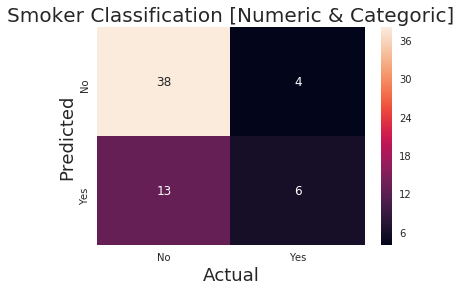

In [37]:
# Display confusion matrix
ml.confusion(dep_test.reshape(dep_test.shape[0]), 
             predicted, ['No', 'Yes'], 2, 'Smoker Classification [Numeric & Categoric]')

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used logistic regression to build a model representation of the _tips_ data to predict if a patron was a smoker or not. Now that you have run the notebook once, go back and make the following changes. Be sure to understand what you have done and the impact on the new classification result.

1. In this model, we did not employ a train:test split. Change the model construction to split the data into 75% training and 25% testing. Do you believe the new model more or less than the original model? Why?
2. Change the features use to drop all categorical features. How does the new model perform? 
3. Try predicting sex (or gender) rather than the `smoker` feature by using all other features. Does the new model perform better or worse than the current model?

-----

-----

[[Back to TOC]](#Table-of-Contents)

### Marginal Effects

One challenge when building a logistic model with multiple independent features is understanding the _true_ effect of any one independent feature. To estimate these effects, one can compute the _marginal effects_, which quantifies the impact one feature has on the prediction while the other features are held constant. Formally this is done by taking the partial derivative of the model with respect to the feature of interest, but we can compute them directly by using the `get_margeff` function from the statsmodels library. The following code cell demonstrates this by calling this method on the logistic regression model `sts_model` that we previously constructed by using the statsmodels library. 

The results displayed agree with what we saw earlier in the fit coefficients, namely that the `total_bill` and `tips` features do not strongly relate to a prediction. For example, a unit change in the `total_bill` feature will induce a change of 0.0157 in the prediction. Of these three features, the `size` has the largest impact at -0.1518, which once again indicates that a smaller `size` feature suggests a higher chance of a smoker, since that marginal effect is negative. We could ask if we see this effect in descriptive statistics. The next two Code cells present the descriptive statistics for the original data split by the `smoker` feature. From this, we see that smokers do tend to be in smaller groups and give slightly smaller tips. However, to fully quantify this interpretation would require employing hypothesis testing, which is beyond the scope of the current notebook.

----

In [38]:
# Move this to text as an aside
mfx = sts_model.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:                  label
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
total_bill     0.0157      0.005      3.203      0.001       0.006       0.025
tip           -0.0187      0.030     -0.618      0.537      -0.078       0.041
size          -0.1518      0.042     -3.638      0.000      -0.234      -0.070


In [39]:
# Smoker descriptive statistics
tdf[tdf['smoker'] == 'Yes'].describe()

,total_bill,tip,size,label
count,93.000000,93.000000,93.000000,93.0
mean,20.756344,3.008710,2.408602,1.0
std,9.832154,1.401468,0.810751,0.0
min,3.070000,1.000000,1.000000,1.0
25%,13.420000,2.000000,2.000000,1.0
50%,17.920000,3.000000,2.000000,1.0
75%,26.860000,3.680000,3.000000,1.0
max,50.810000,10.000000,5.000000,1.0


In [40]:
# Nonsmoker descriptive statistics
tdf[tdf['smoker'] == 'No'].describe()

,total_bill,tip,size,label
count,151.000000,151.000000,151.000000,151.0
mean,19.188278,2.991854,2.668874,0.0
std,8.255582,1.377190,1.017984,0.0
min,7.250000,1.000000,1.000000,0.0
25%,13.325000,2.000000,2.000000,0.0
50%,17.590000,2.740000,2.000000,0.0
75%,22.755000,3.505000,3.000000,0.0
max,48.330000,9.000000,6.000000,0.0


-----

[[Back to TOC]](#Table-of-Contents)

### Odds Ratio

While marginal effect works well for numeric features, we can't take the derivative of a categorical, or discrete feature. Thus, we can also compute the _odds ratio_ to determine the association between the presence or absence of two features. To compute an odds ratio, we hold one categorical value fixed, which is the reference group. This reference category was determined earlier when we held one categorical option out of the fit. Thus, when we calculate an odds ratio for the female instances, it is done with respect to the `sex=male` reference group.

We can use the odds ratio to determine the association, for example, between the `day` feature and the `time` feature, in order to determine if there is a relationship between these two features and the likelihood a patron is a smoker. The value of the odds ratio indicates how much more likely a patron is to be a smoker. We can also compute confidence intervals around these values to quantify the degrees of uncertainty associated with this ratio.

The following Code cells first perform a logistic regression using all three numeric and categoric features on the full data set, and display a summary of the results. Next, we compute the odds ratio and confidence intervals for the different features, which is done for our logistic model by using the exponential function (i.e., the same as going from a logit function to a logistic function). The results indicate that `day=Fri` and `day=Sat` are important, which is also borne out by the fit coefficients.

-----

In [41]:
# Implement simple regression: Result ~ Input
sts_c_model = logit('label ~ total_bill + tip + size + C(sex) + C(day) + C(time)', 
                    data=tdf).fit()

# Display model fit results
sts_c_model.summary()

Optimization terminated successfully.
         Current function value: 0.584335
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                  244
Model:                          Logit   Df Residuals:                      235
Method:                           MLE   Df Model:                            8
Date:                Fri, 26 Jan 2018   Pseudo R-squ.:                  0.1208
Time:                        13:59:14   Log-Likelihood:                -142.58
converged:                       True   LL-Null:                       -162.17
                                        LLR p-value:                 4.550e-06
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5777      0.538     -1.074      0.283      -1.632       0.477
C(sex)[T.Female]     -0.0242      0.311     -0.078      0.938      -0.634       0.586
C(day)[T.Fri]         3.0240      1.107      2.731      0.006       0.853       5.195
C(day)[T.Sat]         2.0200      1.261      1.602      0.109      -0.451       4.492
C(day)[T.Sun]         1.0578      1.274      0.830      0.406      -1.439       3.554
C(time)[T.Dinner]    -1.2317      1.219     -1.010      0.312      -3.621       1.158
total_bill            0.0723      0.025      2.898      0.004       0.023       0.121
tip                  -0.0903      0.144     -0.627      0.531      -0.373       0.192
size                 -0.5874      0.214     -2.750      0.006      -1.006      -0.169
=====================================================================================
"""

In [42]:
# Odds ratios and 95% CI
ci = sts_c_model.conf_int()
ci['OR'] = sts_c_model.params
ci.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(ci))

                       2.5%       97.5%         OR
Intercept          0.195529    1.610648   0.561185
C(sex)[T.Female]   0.530437    1.796312   0.976131
C(day)[T.Fri]      2.347570  180.306787  20.573836
C(day)[T.Sat]      0.636695   89.259933   7.538655
C(day)[T.Sun]      0.237217   34.969570   2.880171
C(time)[T.Dinner]  0.026750    3.183206   0.291804
total_bill         1.023657    1.128765   1.074927
tip                0.688984    1.211680   0.913689
size               0.365666    0.844746   0.555783


In [43]:
#Clean up - removing the temporary directory we created at the beginning of the lesson
!rm -rf $HOME/temp_w2l1

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. Wikipedia article on [Logistic Regression][1]
1. An interesting blog article on performing [logistic regression][2] in Python
2. An implementation of [logistic regression][3] for modeling usage of wells in remote locations
5. A demonstration of logistic regression for [loan prediction][6]
67. A concise discussion on [performance metrics][pm] for classification algorithms
-----

[1]: https://en.wikipedia.org/wiki/Logistic_regression
[2]: http://blog.yhat.com/posts/logistic-regression-and-python.html
[3]: http://slendermeans.org/arm-ch5.html
[6]: http://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/B3.%20Logistic%20Regression%20-%20Analysis.ipynb
[pm]: http://mrvar.fdv.uni-lj.si/pub/mz/mz3.1/vuk.pdf

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 